# Part B: Regression Problem

* **Name** Acharya Atul
* **Matriculation Number** U1923502C
* **Email** atul001@e.ntu.edu.sg

# Question 2
>Neural networks offer much more than fundamental machine learning algorithms. In this part of
the assignment, we will investigate one of its advantages: the use of trainable embeddings. Also,
we will learn how to set up a quick and convenient way of tuning your neural network models.
Instead of using one-hot encoding, an alternative approach is to use embeddings to encode
categorical variables. Such an approach utilises the ability of neural networks to learn richer
representations1 of the data – an edge it has over traditional ML models.


In [1]:
import warnings
warnings.filterwarnings("ignore")

### Neccessary Imports

* **pandas** - Data analysis and manipulation
* **tensorflow** - Modeling neural networks and training them
* **graphviz** - Visualization of model architecture
* **keras_tuner** - Hyperparameter Tuning

In [2]:
!pip install --upgrade tensorflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

import graphviz
from keras.utils.vis_utils import plot_model

try:
    import keras_tuner as kt
except ModuleNotFoundError:
    !pip install keras-tuner --upgrade
    import keras_tuner as kt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 47.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator

2022-10-10 12:29:58.346071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-10 12:29:58.543751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-10-10 12:29:58.543783: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-10 12:29:58.583046: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to r

### Setting the seed for reproducability

>For this assignment we will be using 42 as the seed

In [3]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

### Reading Dataset

In [4]:
df = pd.read_csv('../input/assignment/hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


### Functions to create our dataset and encode features

In [5]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe, shuffle=False):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


### Function to compute $R^2$ score
>$R^2$ = 1 - $\dfrac{\Sigma_i(y_i - \hat{y_i})} {\Sigma_i(y_i - \bar{y_i})}$

In [6]:
from keras import backend as K

def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Part A
>Further split the data from year 2020 and before (i.e. those not in test set) by
using data from year 2020 as validation set and the rest as the training set.

### Splitting Data
>All datapoints until the year 2019 belong in the train set, datapoints with year = 2020 belong in the validation set
and all datapoints from year 2021 and onwards belong to the test set.

***Note***: The test data was grouped in batches for faster inference time 

In [7]:
# Split data

non_test_split_dataframe = df[df['year'] <= 2020]

train_dataframe = df[df['year'] < 2020]
val_dataframe = df[df['year'] == 2020]
test_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)
test_ds = dataframe_to_dataset(test_dataframe, shuffle=False)

non_test_ds = dataframe_to_dataset(non_test_split_dataframe)

train_ds = train_ds.batch(256)
val_ds = val_ds.batch(256)
test_ds = test_ds.batch(256)

non_test_ds = non_test_ds.batch(256)


2022-10-10 12:30:06.329452: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-10-10 12:30:06.329511: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-10 12:30:06.329546: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c79b2b248e4a): /proc/driver/nvidia/version does not exist
2022-10-10 12:30:06.329993: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the

## Part B
> For each categorical variable, replace the one-hot encoding with the layer
tf.keras.layers.Embedding(). Set output_dim = floor(num_categories//divisor).
‘num_categories’ refers to the number of categories in the categorical variable.
‘divisor’ is a parameter which we will tune later (Hint: You will still need the
lookup classes from Q1b. Read the documentation to find out what to change.)
<br><br>The Embedding layer produces a 2D output (3D, including batch), which cannot
be concatenated with the other features. Add a Flatten layer to resolve this. 

### Model Architecture
>The model architecture is similar to Question 1. The difference is that we use an embedding layer for categorical variables to represent them meaningfully in a different space. This helps the model learn better features.
<br><br>The first argument to the embedding is the vocabulary size and the second argument is the output dimension of the feature vector. We add $+1$ to the vocab size to handle unkown $UNK$ categories which may not be present in the training set but might be present in the test set 

***Note***: The *build_model* function takes an argument hp. This is used by keras tuner to perform the search for optimal hyperparameters.
* **Divisor**: hp.Int('Divisor', 1, 2, step=1) (min=1, max=2, step=1)
* **Number of neurons**: (hp.Int('Number of neurons', 4, 32, step=4) (min=4, max=32, step=4)
* **Learning rate**: hp.Float('Learning rate', 1e-4, 2e-1, sampling='log') (min=1e-4, max=2e-1, sampling=’log’)

In [8]:
def build_model(hp):
    # Categorical features encoded as integers
    month = keras.Input(shape=(1,), name="month", dtype="int64")
    month_encoded = encode_categorical_feature(month, "month", train_ds, False)

    # Categorical feature encoded as string
    flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
    storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

    flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
    storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

    # Numerical features
    dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
    floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
    dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
    degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
    eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
    remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")

    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
    degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
    remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

    all_inputs = [
        month,
        storey_range,
        flat_model_type,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby,
    ]

    #Embedding to categorical features
    # Categorical features encoded as integers
    month_encoded = encode_categorical_feature(month, "month", train_ds, False)
    month_embedding = layers.Embedding(int(len(np.unique(train_dataframe['month']))+1), int(np.floor((len(np.unique(train_dataframe['month']))+1)/hp.Int('Divisor', 1, 2, step=1))))(month_encoded)
    month_flatten = layers.Flatten()(month_embedding)

    #Categorical feature encoded as string
    flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
    flat_model_type_embedding = layers.Embedding(int(len(np.unique(train_dataframe['flat_model_type']))+1), int(np.floor((len(np.unique(train_dataframe['flat_model_type']))+1)/hp.Int('Divisor', 1, 2, step=1))))(flat_model_type_encoded)
    flat_model_type_flatten = layers.Flatten()(flat_model_type_embedding)

    storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)
    storey_range_embedding = layers.Embedding(int(len(np.unique(train_dataframe['storey_range']))+1), int(np.floor((len(np.unique(train_dataframe['storey_range']))+1)/hp.Int('Divisor', 1, 2, step=1))))(storey_range_encoded)
    storey_range_flatten = layers.Flatten()(storey_range_embedding)

    concat_features= layers.concatenate(
        [
            month_flatten,
            flat_model_type_flatten,
            storey_range_flatten,
            floor_area_sqm_encoded,
            dist_to_dhoby_encoded,
            dist_to_nearest_stn_encoded,
            degree_centrality_encoded,
            eigenvector_centrality_encoded, 
            remaining_lease_years_encoded
        ]
    )
    

    hidden_layer = layers.Dense(hp.Int('Number of neurons', 4, 32, step=4), activation="relu")(concat_features)
    dense_layer = layers.Dense(1, activation="linear")(hidden_layer)
    model = keras.Model(all_inputs, dense_layer)
    opt=keras.optimizers.Adam(learning_rate=hp.Float('Learning rate', 1e-4, 2e-1, sampling='log'))
    model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError(), r2])

    return model

## Part C
>Via a callback, introduce early stopping (based on val_loss, with patience of
10 epochs) to the model.
Using this as a reference, use KerasTuner (with the RandomSearch algorithm)
to tune the model on the validation set, according to the following ranges:
>- Number of neurons: min=4, max=32, step=4
>- Learning rate: min=1e-4, max=2e-1, sampling=’log’
>- Divisor: min=1, max=2, step=1
>Run 10 iterations of parameter search (i.e. max_trials=10), each for 50 epochs
and report the best set of hyperparameters (based on validation accuracy). 

### Setting constants for training and hyperparameter search

In [9]:
max_trials = 10
num_epochs = 50

### Instantiating the tuner

In [10]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=max_trials)

### Hyperparameter Search

In [11]:
tuner.search(
            train_ds,
            validation_data=val_ds,
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')],
            epochs=num_epochs
            )

Trial 10 Complete [00h 01m 49s]
val_loss: 24106113024.0

Best val_loss So Far: 3171257344.0
Total elapsed time: 00h 30m 11s


### Save the results of the tuner into a variable

In [12]:
%%capture tuner_output --no-stderr
tuner.results_summary()

### Extract Tuner results

In [13]:
result_string = tuner_output.stdout
result_string = result_string.split("\n")

divisor_list = [x[x.find(':')+2:] for x in result_string if 'Divisor' in x]
hidden_size_list = [x[x.find(':')+2:] for x in result_string if 'Number of neurons' in x]
learning_rate_list = [x[x.find(':')+2:] for x in result_string if 'Learning rate' in x]
score_list = [x[x.find(':')+2:] for x in result_string if 'Score' in x]

### Display the tuner results

In [14]:
records = {}
records['Divisor'] = divisor_list
records['Hidden Size'] = hidden_size_list
records['Learning Rate'] = learning_rate_list
records['Score'] = score_list

hyperparameter_table = pd.DataFrame(records)
hyperparameter_table['Score'] = pd.to_numeric(hyperparameter_table['Score'])
hyperparameter_table = hyperparameter_table.sort_values('Score')

In [15]:
hyperparameter_table.head(max_trials)

,Divisor,Hidden Size,Learning Rate,Score
0,2,16,0.06805250998340012,3.171257e+09
1,2,4,0.08200053321721724,4.580778e+09
2,2,12,0.01113262387652895,8.155260e+09
3,1,24,0.0019608369359383425,2.040594e+10
4,2,20,0.00035649925917289845,2.403876e+10
5,2,24,0.0008419693545704217,2.406642e+10
6,1,28,0.0004948066745302922,2.407448e+10
7,1,12,0.0012598966611313636,2.410611e+10
8,1,20,0.000201065526779238,2.412770e+10
9,2,8,0.0001465335544953214,1.667990e+11


### Get the best value of hyperparameters

In [16]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

params = ['Divisor', 'Number of neurons', 'Learning rate']

print('----- Best Hyperparamers -----')
for param in params:
    print(f"{param}: {best_hyperparameters.get(name=param)}")

----- Best Hyperparamers -----
Divisor: 2
Number of neurons: 16
Learning rate: 0.06805250998340012


In [17]:
best_divisor = best_hyperparameters.get(name='Divisor')
best_hidden_size = best_hyperparameters.get(name='Number of neurons')
best_learning_rate = best_hyperparameters.get(name='Learning rate')

## Part D
>Using the best model configuration, train a model on the non-test split (i.e.
year 2020 and before) for 50 epochs. Generate a plot to show how the train
and test root mean square errors (RMSE) changes across epochs.
(Tip: You can skip the first few epochs if the plot gets dominated by them) 

### Create model with best configuration
>**Divisor**: 2<br>
**Number of neurons**: 16<br>
**Learning rate**: 0.06805250998340012

In [18]:
def create_model():

    # Categorical features encoded as integers
    month = keras.Input(shape=(1,), name="month", dtype="int64")
    month_encoded = encode_categorical_feature(month, "month", non_test_ds, False)

    # Categorical feature encoded as string
    flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
    storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

    flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", non_test_ds, True)
    storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", non_test_ds, True)

    # Numerical features
    dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
    floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
    dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
    degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
    eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
    remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")

    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", non_test_ds)
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", non_test_ds)
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", non_test_ds)
    degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", non_test_ds)
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", non_test_ds)
    remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", non_test_ds)

    all_inputs = [
        month,
        storey_range,
        flat_model_type,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby,
    ]

    #Embedding to categorical features
    # Categorical features encoded as integers
    month_encoded = encode_categorical_feature(month, "month", non_test_ds, False)
    month_embedding = layers.Embedding(int(len(np.unique(non_test_split_dataframe['month']))+1), int(np.floor((len(np.unique(non_test_split_dataframe['month']))+1)/best_divisor)))(month_encoded)
    month_flatten = layers.Flatten()(month_embedding)

    #Categorical feature encoded as string
    flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", non_test_ds, True)
    flat_model_type_embedding = layers.Embedding(int(len(np.unique(non_test_split_dataframe['flat_model_type']))+1), int(np.floor((len(np.unique(non_test_split_dataframe['flat_model_type']))+1)/best_divisor)))(flat_model_type_encoded)
    flat_model_type_flatten = layers.Flatten()(flat_model_type_embedding)

    storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", non_test_ds, True)
    storey_range_embedding = layers.Embedding(int(len(np.unique(non_test_split_dataframe['storey_range']))+1), int(np.floor((len(np.unique(non_test_split_dataframe['storey_range']))+1)/best_divisor)))(storey_range_encoded)
    storey_range_flatten = layers.Flatten()(storey_range_embedding)

    concat_features= layers.concatenate(
        [
            month_flatten,
            flat_model_type_flatten,
            storey_range_flatten,
            floor_area_sqm_encoded,
            dist_to_dhoby_encoded,
            dist_to_nearest_stn_encoded,
            degree_centrality_encoded,
            eigenvector_centrality_encoded, 
            remaining_lease_years_encoded
        ]
    )


    hidden_layer = layers.Dense(best_hidden_size, activation="relu")(concat_features)
    dense_layer = layers.Dense(1, activation="linear")(hidden_layer)
    model = keras.Model(all_inputs, dense_layer)
    opt=keras.optimizers.Adam(learning_rate=best_learning_rate)
    model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [19]:
model = create_model()

### Visualize Model Architecture

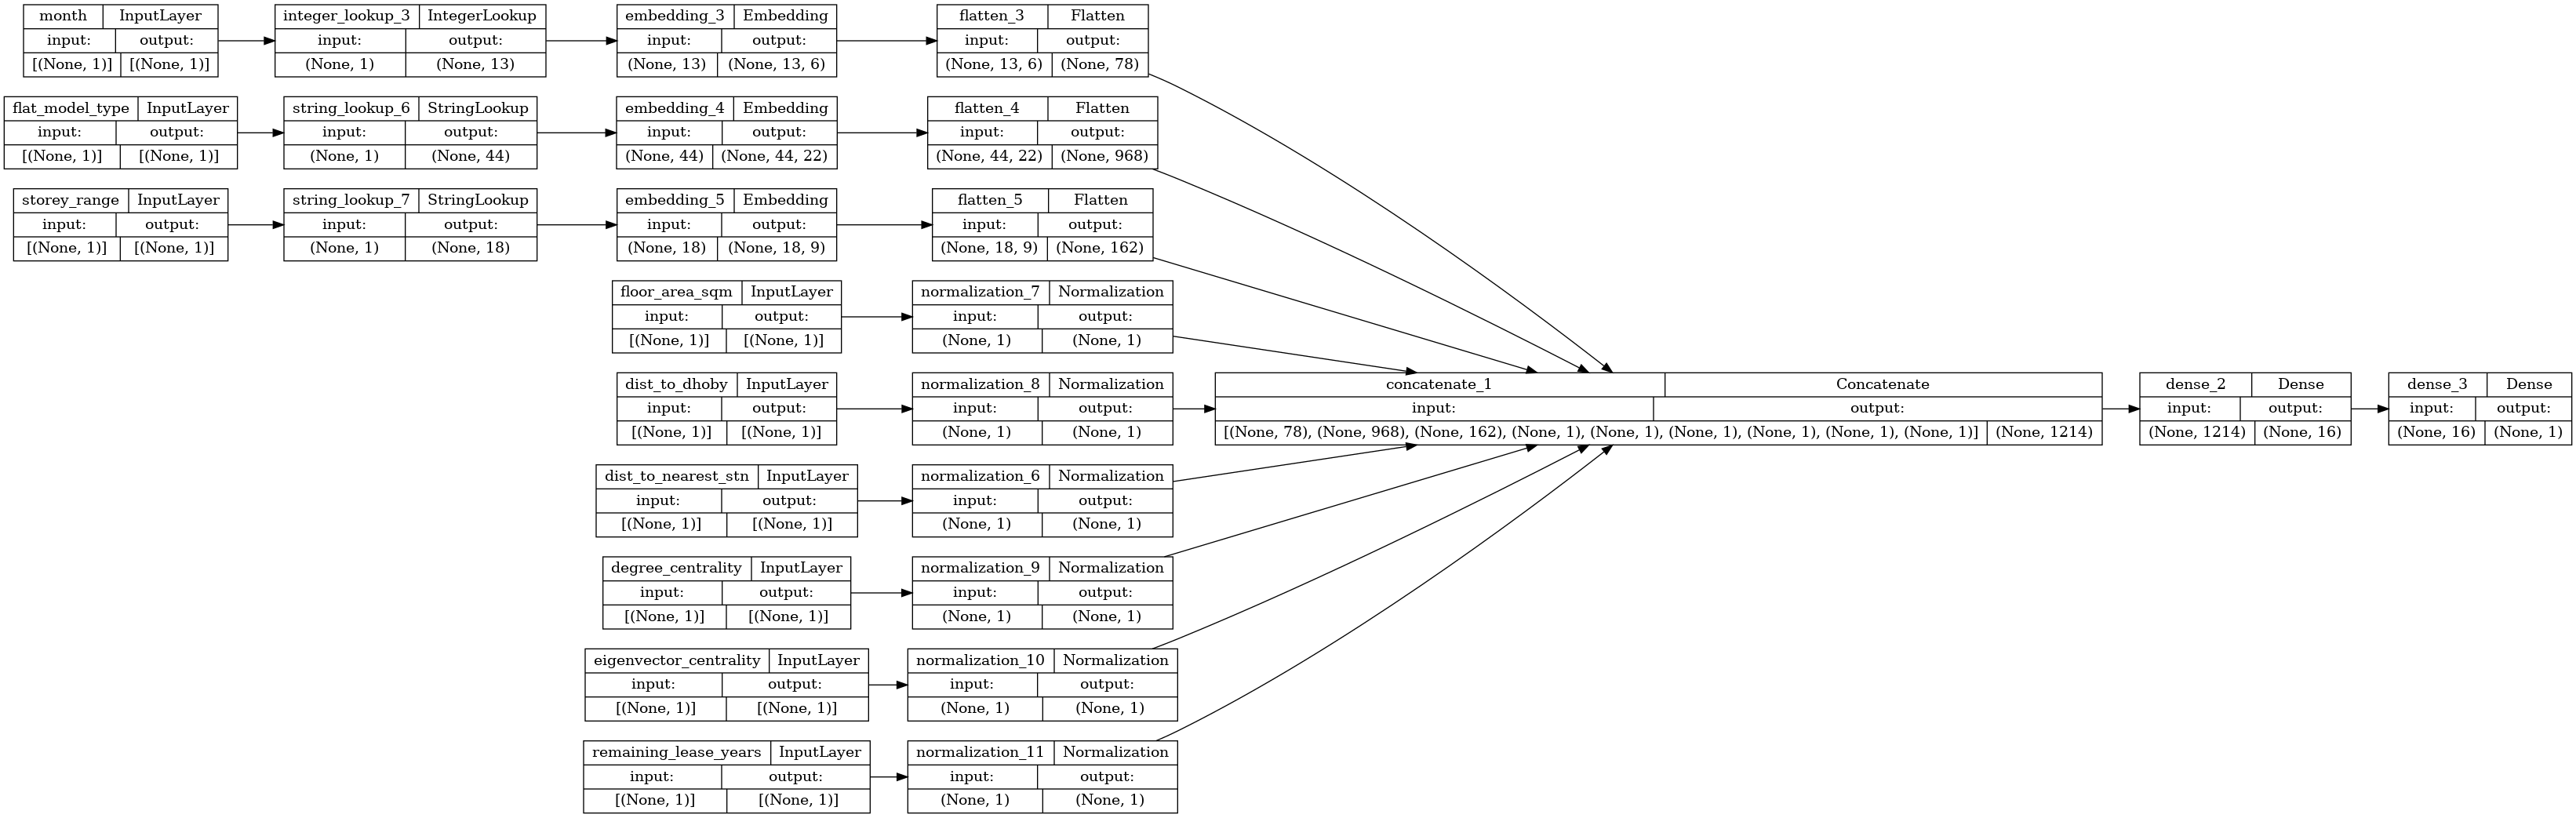

In [20]:
plot_model(model, show_shapes=True, rankdir="LR")

### ModelCheckpoint to save the best model

In [21]:
checkpoint_filepath = 'tmp/checkpoint/'

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_weights_only=True,
    save_best_only=True)

### Train model

In [22]:
history = model.fit(non_test_ds, epochs=num_epochs, validation_data=test_ds, callbacks=[model_checkpoint_callback])

Epoch 1/50
342/342 [==============================] - 6s 13ms/step - loss: 41209114624.0000 - mean_squared_error: 41209114624.0000 - root_mean_squared_error: 203000.2812 - val_loss: 28574584832.0000 - val_mean_squared_error: 28574584832.0000 - val_root_mean_squared_error: 169040.1875
Epoch 2/50
342/342 [==============================] - 4s 12ms/step - loss: 21576009728.0000 - mean_squared_error: 21576009728.0000 - root_mean_squared_error: 146887.7500 - val_loss: 20698087424.0000 - val_mean_squared_error: 20698087424.0000 - val_root_mean_squared_error: 143868.2969
Epoch 3/50
342/342 [==============================] - 4s 13ms/step - loss: 12434079744.0000 - mean_squared_error: 12434079744.0000 - root_mean_squared_error: 111508.2031 - val_loss: 14682006528.0000 - val_mean_squared_error: 14682006528.0000 - val_root_mean_squared_error: 121169.3281
Epoch 4/50
342/342 [==============================] - 4s 13ms/step - loss: 9236328448.0000 - mean_squared_error: 9236328448.0000 - root_mean_squa

### Plot of train and test root mean square errors (RMSE)

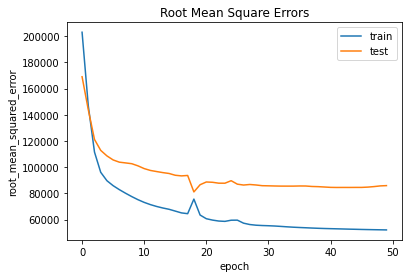

In [23]:
plt.figure()
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Root Mean Square Errors')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

## Part E
>Using the model from the best epoch, report the test R2 value and show the
top 30 test samples with the largest errors. List down any trends you find in
these samples and suggest ways to reduce these errors.
(Tip: Add the prediction error as a column in the DataFrame and sort by it.)

### Load weights of best model

In [24]:
best_model = create_model()
best_model.load_weights(checkpoint_filepath)

### Predict on the test dataset

In [25]:
predicted = model.predict(test_ds)

180/180 [==============================] - 1s 7ms/step


In [26]:
target = np.concatenate([y for x, y in test_ds], axis=0)
target = np.expand_dims(target, axis=1)

In [27]:
print(predicted.shape)
print(target.shape)

(46042, 1)
(46042, 1)


### Test $R^2$ value

In [28]:
print(f'R2 value: {r2(tf.convert_to_tensor(np.double(target)), tf.convert_to_tensor(np.double(predicted)))}')

R2 value: 0.732009377707046


### Calculate the error for each test sample
>$error = (y_i - \hat{y})^2$

In [29]:
squared_error = np.square(target - predicted)
print(squared_error.shape)

(46042, 1)


### Sort the errors in descending order

In [30]:
test_dataframe['squared_error'] = squared_error
table = test_dataframe.sort_values('squared_error', ascending=False)

### Display top 30 samples with the highest error

In [31]:
table.head(30)

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price,squared_error
114504,12,2021,6 TOH YI DRIVE,Beauty World,0.428356,8.948410,0.016807,0.001358,"EXECUTIVE, Maisonette",66.666667,154.0,04 TO 06,1238000.0,2.289526e+11
117054,4,2022,260A ANG MO KIO STREET 21,Ang Mo Kio,1.722450,7.861222,0.016807,0.006243,"5 ROOM, Improved",95.166667,113.0,28 TO 30,1150000.0,2.062453e+11
111790,11,2021,46 SENG POH ROAD,Tiong Bahru,0.581977,2.309477,0.016807,0.047782,"3 ROOM, Standard",50.166667,88.0,01 TO 03,780000.0,2.059186e+11
120164,1,2022,2 TOH YI DRIVE,Beauty World,0.271583,9.003026,0.016807,0.001358,"EXECUTIVE, Maisonette",65.666667,146.0,07 TO 09,1202000.0,2.022861e+11
117058,6,2022,260A ANG MO KIO STREET 21,Ang Mo Kio,1.722450,7.861222,0.016807,0.006243,"5 ROOM, Improved",95.083333,113.0,19 TO 21,1100000.0,1.882733e+11
117052,2,2022,260A ANG MO KIO STREET 21,Ang Mo Kio,1.722450,7.861222,0.016807,0.006243,"5 ROOM, Improved",95.333333,113.0,16 TO 18,1050000.0,1.860109e+11
114505,12,2021,7 TOH YI DRIVE,Beauty World,0.473544,8.936025,0.016807,0.001358,"EXECUTIVE, Apartment",66.750000,142.0,04 TO 06,1125000.0,1.846294e+11
125467,5,2022,156 PASIR RIS STREET 13,Tampines East,1.192284,14.877669,0.016807,0.000127,"EXECUTIVE, Maisonette",71.750000,189.0,07 TO 09,1138888.0,1.836889e+11
117057,5,2022,260A ANG MO KIO STREET 21,Ang Mo Kio,1.722450,7.861222,0.016807,0.006243,"5 ROOM, Improved",95.083333,113.0,13 TO 15,1028000.0,1.834737e+11
117060,7,2022,260B ANG MO KIO STREET 21,Ang Mo Kio,1.745057,7.818413,0.016807,0.006243,"5 ROOM, Improved",95.000000,113.0,13 TO 15,1025000.0,1.818333e+11


### Trends in the top 30 samples
* Majority of the datapoints have *nearest_stn* as "Ang Mo Kio".
* Most of the datapoints have *dist_to_dhoby* $\epsilon$ (7, 9) range.
* Almost all of the datapoints are 5 bedroom houses EXECUTIVE Maisonettes which seem to be very expensive.
* The resale price of all these datapoints is very high.  

### Preventing Errors
* Gather more data with these trends to help the model learn better from this distribution
* Train a separate model on the datapoints exhibiting these trends and see if this specialized model performs better
* Create an outlier detection algorithm (eg: *Isolation Forest*) that predicts the outlier score of a datapoint. Add this as a separate column in the dataset to allow the model to know that this is an outlier.